# Report for Ratings-Results

This report can be used to get an overview on the state of the evaluation.<br/>
It pulls the current ratings from firebase and uses different aggregations in order to create a number of visualizations and statistics.

### Pulling the data

In [1]:
import report

report.create_report_files(
    "../keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
    "ratings.xlsx",
    "pairs.xlsx",
)

### Loading and displaying the raw data

In [10]:
import pandas as pd

pairs = pd.read_excel("./pairs.xlsx")
pairs.columns.values

array(['Unnamed: 0', 'rotation', 'model_2', 'model_1', 'size', 'dataset',
       'position', 'high_detail', 'n_ratings', 'id'], dtype=object)

In [11]:
ratings = pd.read_excel("./ratings.xlsx")
ratings.columns.values

array(['Unnamed: 0', 'rating_1', 'user_id', 'pair_id', 'rating_2', 'id'],
      dtype=object)

### How many ratings are there per pair?

In [29]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
df_ratings_count_computed = pd.DataFrame.from_dict({
    "pair_id": ratings_count_computed.index,
    "count": ratings_count_computed.values
}).sort_values("count", ascending=False)
df_ratings_count_computed

,pair_id,count
0,5dwojHXzFd2RzJ2ZPNtD,13
1,BGOjoywll3sSUYo2pBwY,13
3,PqpflZDmB5tBiM15v9MQ,13
2,OyhrkDZsWy64SkqfZAY5,12


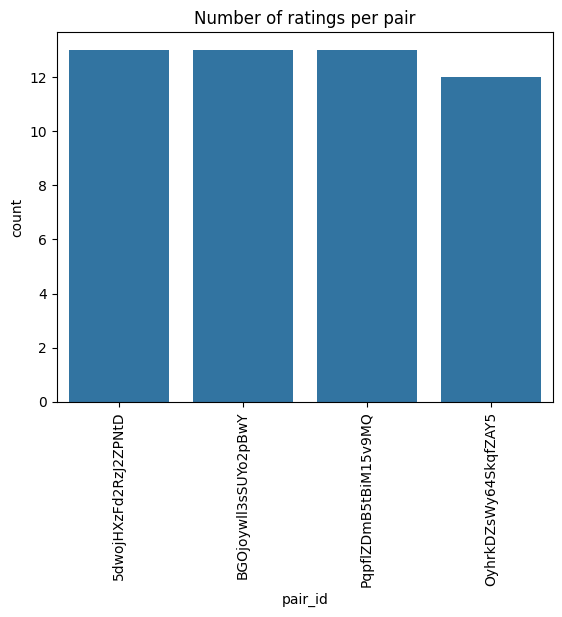

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(df_ratings_count_computed, x="pair_id", y="count")
plt.xticks(rotation=90)
plt.title("Number of ratings per pair")
plt.show()

In [31]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

### How many ratings per user?

There are 8 users


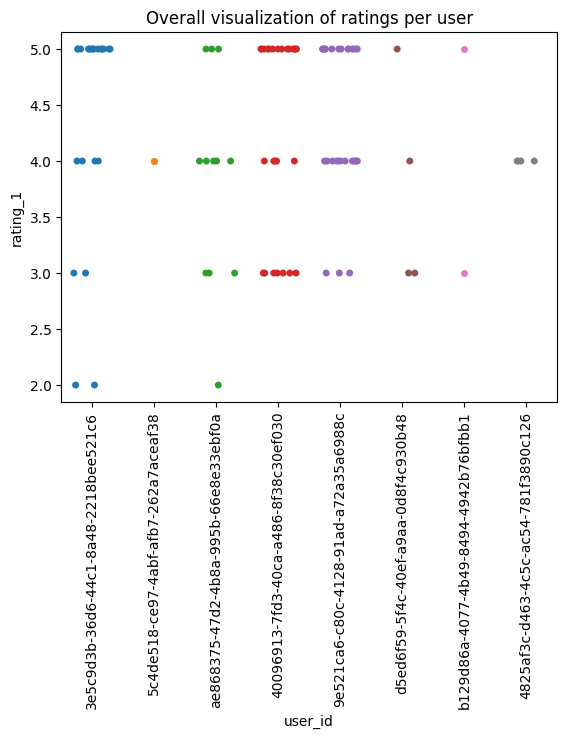

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt 

n_users = len(ratings["user_id"].unique())
print(f"There are {n_users} users")

sns.stripplot(ratings, x="user_id", y="rating_1", jitter=0.3, hue="user_id")
plt.xticks(rotation=90)

sns.stripplot(ratings, x="user_id", y="rating_2", jitter=0.3, hue="user_id")
plt.xticks(rotation=90)

plt.title("Overall visualization of ratings per user")
plt.show()

In [41]:
ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user = pd.DataFrame.from_dict(
    {"user_id": ratings_per_user.index, "count": ratings_per_user.values}
).sort_values("count", ascending=False)
df_ratings_per_user

,user_id,count
4,9e521ca6-c80c-4128-91ad-a72a35a6988c,15
1,40096913-7fd3-40ca-a486-8f38c30ef030,13
0,3e5c9d3b-36d6-44c1-8a48-2218bee521c6,11
5,ae868375-47d2-4b8a-995b-66e8e33ebf0a,6
7,d5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48,2
2,4825af3c-d463-4c5c-ac54-781f3890c126,2
3,5c4de518-ce97-4abf-afb7-262a7aceaf38,1
6,b129d86a-4077-4b49-8494-4942b76bfbb1,1


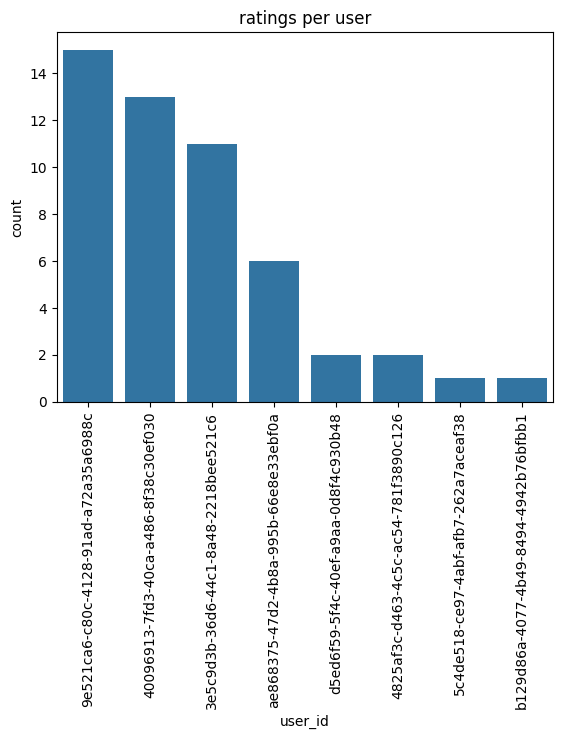

In [43]:
sns.barplot(df_ratings_per_user, x="user_id", y="count")
plt.xticks(rotation=90)
plt.title("ratings per user")
plt.show()

### How many times has every individual model been rated?

In [80]:
rating_records = []

for idx, row in ratings.iterrows():
    pair = pairs[row["pair_id"] == pairs["id"]].iloc[0]
    rating_records.append(
        {
            "model_name": str(pair["model_1"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "rating": row["rating_1"],
            "user_id": row["user_id"],
        }
    )
    rating_records.append(
        {
            "model_name": str(pair["model_2"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "rating": row["rating_2"],
            "user_id": row["user_id"],
        }
    )

df_ratings_per_model = pd.DataFrame.from_records(rating_records)
df_ratings_per_model

,model_name,rating,user_id
0,default-truck-high-1,5,3e5c9d3b-36d6-44c1-8a48-2218bee521c6
1,mcmc-truck-high-1,4,3e5c9d3b-36d6-44c1-8a48-2218bee521c6
2,default-truck-high-1,4,5c4de518-ce97-4abf-afb7-262a7aceaf38
3,mcmc-truck-high-1,4,5c4de518-ce97-4abf-afb7-262a7aceaf38
4,default-truck-medium-1,5,ae868375-47d2-4b8a-995b-66e8e33ebf0a
...,...,...,...
97,mcmc-truck-high-1,5,d5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48
98,default-truck-high-1,5,9e521ca6-c80c-4128-91ad-a72a35a6988c
99,mcmc-truck-high-1,4,9e521ca6-c80c-4128-91ad-a72a35a6988c
100,default-truck-low-1,4,ae868375-47d2-4b8a-995b-66e8e33ebf0a


In [83]:
count_ratings_per_model = df_ratings_per_model.groupby("model_name")["model_name"].count()
df_count_ratings_per_model = pd.DataFrame.from_dict({
    "model_name": count_ratings_per_model.index,
    "n_ratings": count_ratings_per_model.values,
}).sort_values("n_ratings", ascending=False)
df_count_ratings_per_model

,model_name,n_ratings
0,default-truck-extended-1,13
1,default-truck-high-1,13
3,default-truck-medium-1,13
4,mcmc-truck-extended-1,13
7,mcmc-truck-medium-1,13
5,mcmc-truck-high-1,13
2,default-truck-low-1,12
6,mcmc-truck-low-1,12


### Whats the mean opinion score (MOS) per dataset, per model, per size? (assuming truck dataset for now)

In [100]:
df_ratings_per_model["model"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[0]
)
df_ratings_per_model["dataset"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[1]
)
df_ratings_per_model["size"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[2]
)
df_grouped = (
    df_ratings_per_model.groupby(["model", "dataset", "size"])
    .agg({"rating": "mean"})
    .reset_index()
)
df_grouped["n_splats"] = df_grouped["size"].apply(
    lambda size: {
        "low": 117856,
        "medium": 412235,
        "high": 1093135,
        "extended": 2186270,
    }[size]
)
df_grouped

,model,dataset,size,rating,n_splats
0,default,truck,extended,4.769231,2186270
1,default,truck,high,4.615385,1093135
2,default,truck,low,4.666667,117856
3,default,truck,medium,4.692308,412235
4,mcmc,truck,extended,3.769231,2186270
5,mcmc,truck,high,3.769231,1093135
6,mcmc,truck,low,3.916667,117856
7,mcmc,truck,medium,3.692308,412235


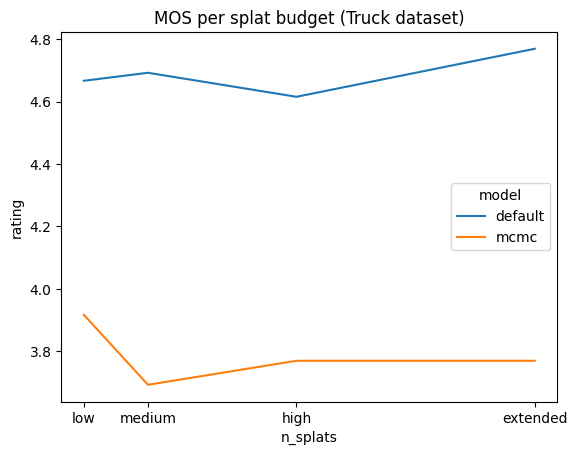

In [114]:
ax = plt.subplot()
sns.lineplot(df_grouped, x="n_splats", y="rating", hue="model", ax=ax)
plt.title("MOS per splat budget (Truck dataset)")
ax.set_xticks([117856, 412235, 1093135, 2186270], ["low", "medium", "high", "extended"])
plt.show()

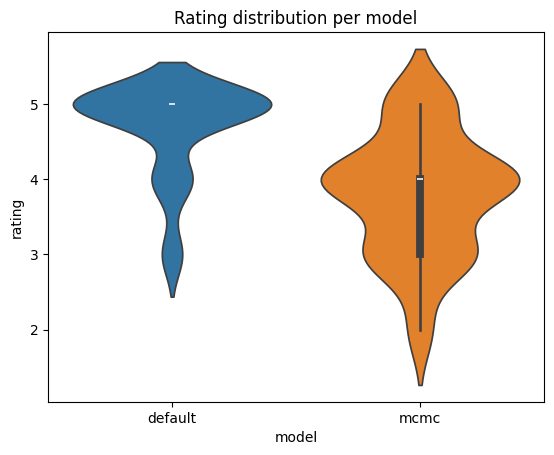

In [116]:
sns.violinplot(df_ratings_per_model, x="model", y="rating", hue="model")
plt.title("Rating distribution per model")
plt.show()